# 加载数据集

In [1]:
from datasets import load_dataset
train_dataset = load_dataset('csv',data_files='../data/MyDataset/data2/train_dataset.csv',split='train')
valid_dataset = load_dataset('csv',data_files='../data/MyDataset/data2/valid_dataset.csv',split='train')
test_dataset = load_dataset('csv',data_files='../data/MyDataset/data2/test_dataset.csv',split='train')

Using custom data configuration default-5602383f9cde0ea3
Reusing dataset csv (/home/chenli/.cache/huggingface/datasets/csv/default-5602383f9cde0ea3/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
Using custom data configuration default-062c84d526dcea84
Reusing dataset csv (/home/chenli/.cache/huggingface/datasets/csv/default-062c84d526dcea84/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
Using custom data configuration default-0f8395db45727ded
Reusing dataset csv (/home/chenli/.cache/huggingface/datasets/csv/default-0f8395db45727ded/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


In [2]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 2755
})

# 数据预处理

In [3]:
from transformers import AutoTokenizer
    
check_point = "schen/longformer-chinese-base-4096"
# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(check_point)
tokenizer

PreTrainedTokenizerFast(name_or_path='schen/longformer-chinese-base-4096', vocab_size=21128, model_max_len=4096, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [4]:
# 分词，Longformer模型
def preprocess_function(data):
    return tokenizer(data['text'],padding='max_length',max_length=1200,truncation=True)

In [5]:
encoded_train_dataset = train_dataset.map(function=preprocess_function,
                     batched=True,
                     remove_columns=['text'])
encoded_train_dataset = encoded_train_dataset.rename_column("label", "labels")

encoded_valid_dataset = valid_dataset.map(function=preprocess_function,
                     batched=True,
                     remove_columns=['text'])
encoded_valid_dataset = encoded_valid_dataset.rename_column("label", "labels")

encoded_test_dataset = test_dataset.map(function=preprocess_function,
                     batched=True,
                     remove_columns=['text'])
encoded_test_dataset = encoded_test_dataset.rename_column("label", "labels")

Loading cached processed dataset at /home/chenli/.cache/huggingface/datasets/csv/default-5602383f9cde0ea3/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-664c6d8f0e33a15f.arrow
Loading cached processed dataset at /home/chenli/.cache/huggingface/datasets/csv/default-062c84d526dcea84/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-494bf07d72423656.arrow
Loading cached processed dataset at /home/chenli/.cache/huggingface/datasets/csv/default-0f8395db45727ded/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-fa49ed333d9e9153.arrow


# 数据集加载器

In [6]:
import torch
from transformers.data.data_collator import DataCollatorWithPadding
batch_size = 2
train_dataloader = torch.utils.data.DataLoader(dataset = encoded_train_dataset,batch_size=batch_size,collate_fn=DataCollatorWithPadding(tokenizer),shuffle=True,drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(dataset = encoded_valid_dataset,batch_size=batch_size,collate_fn=DataCollatorWithPadding(tokenizer),shuffle=True,drop_last=True)
test_dataloader = torch.utils.data.DataLoader(dataset = encoded_test_dataset,batch_size=batch_size,collate_fn=DataCollatorWithPadding(tokenizer),shuffle=True,drop_last=True)

In [7]:
dataloaders = {
    "train": train_dataloader,
    "validation": valid_dataloader
}

In [8]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f4d9a3ab190>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7f4c0f603850>}

# 模型

## Longformer + BiGRU

激活函数是ReLU

In [9]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        # 接一个BiGRU
        self.gru = nn.GRU(input_size=768,hidden_size=512,batch_first=True,bidirectional=True,dropout=0.5)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        # 加多一个线性层
        self.linear = nn.Sequential(
            nn.Linear(1024,512),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(512,2)
        )
        

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state # 维度 [batch,seq,hidden_size]
        output,h_n = self.gru(output)
        output = output[:,-1,:] # [batch,1024]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output

# 如果显卡的话就使用显卡
model = NeuralNetwork().to(device)
print(model)

Using cuda:1 device


Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.10.attention.self.query_global.weight', 'bert.encoder.layer.5.attention.self.value_global.bias', 'bert.encoder.layer.6.attention.self.key_global.bias', 'bert.encoder.layer.1.attention.self.value_global.bias', 'bert.encoder.layer.1.attention.self.key_global.weight', 'bert.encoder.layer.9.attention.self.key_global.weight', 'bert.encoder.layer.5.attention.self.key_global.bias', 'bert.encoder.layer.7.attention.self.query_global.bias', 'bert.encoder.layer.7.attention.self.key_global.weight', 'bert.encoder.layer.5.attention.self.key_global.weight', 'bert.encoder.layer.3.attention.self.query_global.weight', 'bert.encoder.layer.9.attention.self.query_global.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.0.attention.self.key_global.bias', 'bert.encoder.layer.8.attention.self.key_global.weight', 'cls.predictions.transform.dense.wei

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

激活函数是Sigmod

In [9]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
from transformers import AutoModel

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.longformer = AutoModel.from_pretrained(check_point)
        # 接一个BiGRU
        self.gru = nn.GRU(input_size=768,hidden_size=512,batch_first=True,bidirectional=True,dropout=0.5)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        # 加多一个线性层
        self.linear = nn.Sequential(
            nn.Linear(1024,512),
            torch.nn.Dropout(0.5),
            torch.nn.Sigmoid(),
            nn.Linear(512,2)
        )
        

    def forward(self,input_ids,token_type_ids,attention_mask):
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        output = self.longformer(input_ids,token_type_ids,attention_mask).last_hidden_state # 维度 [batch,seq,hidden_size]
        output,h_n = self.gru(output)
        output = output[:,-1,:] # [batch,1024]
        # 然后输送给分类的linear层
        output = self.linear(output)
        return output

# 如果显卡的话就使用显卡
model = NeuralNetwork().to(device)
print(model)

Using cuda:1 device


Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['bert.encoder.layer.6.attention.self.query_global.bias', 'bert.encoder.layer.0.attention.self.key_global.weight', 'bert.encoder.layer.7.attention.self.query_global.bias', 'bert.encoder.layer.9.attention.self.query_global.weight', 'bert.encoder.layer.5.attention.self.query_global.bias', 'bert.encoder.layer.3.attention.self.query_global.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'bert.encoder.layer.3.attention.self.query_global.weight', 'bert.encoder.layer.2.attention.self.query_global.weight', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.9.attention.self.key_global.weight', 'bert.encoder.layer.9.attention.self.query_global.bias', 'bert.encoder.layer.1.attention.self.value_global.bias', 'bert.encoder.layer.5.attention.self.query_global.weight', 'bert.encoder.layer.2.attention.self.value_global.bias', 'ber

NeuralNetwork(
  (longformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

# 训练模块定义

In [10]:
from livelossplot import PlotLosses
# train on cuda if available
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

def train_model(dataloader,model, criterion, optimizer,lr_scheduler, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for batch, data in enumerate(dataloader[phase],start=1):
                labels = data.labels.to(device)
                input_ids = data.input_ids.to(device)
                token_type_ids = data.token_type_ids.to(device)
                attention_mask = data.attention_mask.to(device)
                
                pred = model(input_ids,token_type_ids,attention_mask)
                loss = criterion(pred, labels)

                if phase == 'train':
                    loss.backward() # 向后传播
                    optimizer.step() # 算完梯度下降之后更改参数
                    lr_scheduler.step() # 对学习率进行调整
                    optimizer.zero_grad() # 把之前的梯度都清掉
                    

                _, preds = torch.max(pred, 1)
                running_loss += loss.detach()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

# 开始训练

## 20221208 Longformer+BiGRU 模型训练
截断长度为1200 <br>
激活函数是ReLU

In [11]:
from transformers import AdamW, get_scheduler

learning_rate = 1e-5 # 定义学习率
epoch_num = 10 # 轮次定义

criterion = nn.CrossEntropyLoss() # 损失函数，交叉熵
optimizer = AdamW(model.parameters(), lr=learning_rate) # Adamw一个常用的优化器
lr_scheduler = get_scheduler(
    "linear",# 使用线性的方式，慢慢往下降
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(dataloaders['train']),
)

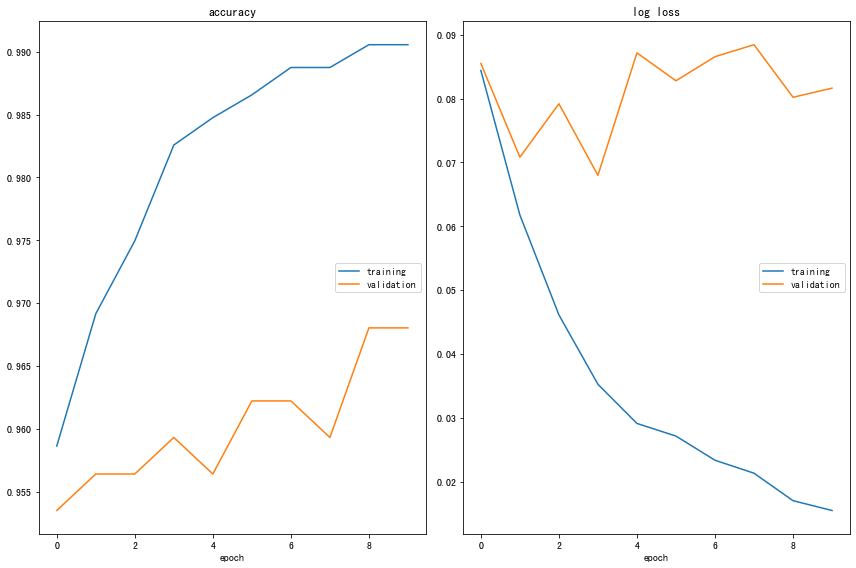

accuracy
	training         	 (min:    0.959, max:    0.991, cur:    0.991)
	validation       	 (min:    0.953, max:    0.968, cur:    0.968)
log loss
	training         	 (min:    0.016, max:    0.084, cur:    0.016)
	validation       	 (min:    0.068, max:    0.088, cur:    0.082)


In [12]:
train_model(dataloaders,model, criterion, optimizer,lr_scheduler,num_epochs=epoch_num)

### 实验结果分析

较小的batch_size可能会使得网络有明显的震荡

## 20221209 Longformer+BiGRU模型训练
截断长度为1200 <br>
激活函数Sigmod <br>
validation batch_size 为2

In [11]:
from transformers import AdamW, get_scheduler

learning_rate = 1e-5 # 定义学习率
epoch_num = 10 # 轮次定义

criterion = nn.CrossEntropyLoss() # 损失函数，交叉熵
optimizer = AdamW(model.parameters(), lr=learning_rate) # Adamw一个常用的优化器
lr_scheduler = get_scheduler(
    "linear",# 使用线性的方式，慢慢往下降
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(dataloaders['train']),
)

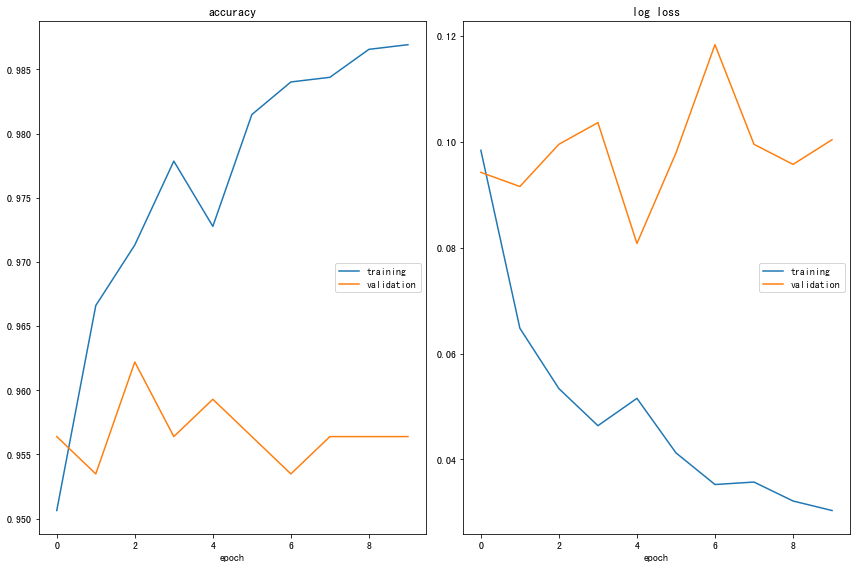

accuracy
	training         	 (min:    0.951, max:    0.987, cur:    0.987)
	validation       	 (min:    0.953, max:    0.962, cur:    0.956)
log loss
	training         	 (min:    0.030, max:    0.098, cur:    0.030)
	validation       	 (min:    0.081, max:    0.118, cur:    0.100)


In [12]:
train_model(dataloaders,model, criterion, optimizer,lr_scheduler,num_epochs=epoch_num)

## 20221209 Longformer+BiGRU模型训练
截断长度为1200 <br>
激活函数是ReLU <br>
epoch=20

In [11]:
from transformers import AdamW, get_scheduler

learning_rate = 1e-5 # 定义学习率
epoch_num = 20 # 轮次定义

criterion = nn.CrossEntropyLoss() # 损失函数，交叉熵
optimizer = AdamW(model.parameters(), lr=learning_rate) # Adamw一个常用的优化器
lr_scheduler = get_scheduler(
    "linear",# 使用线性的方式，慢慢往下降
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(dataloaders['train']),
)

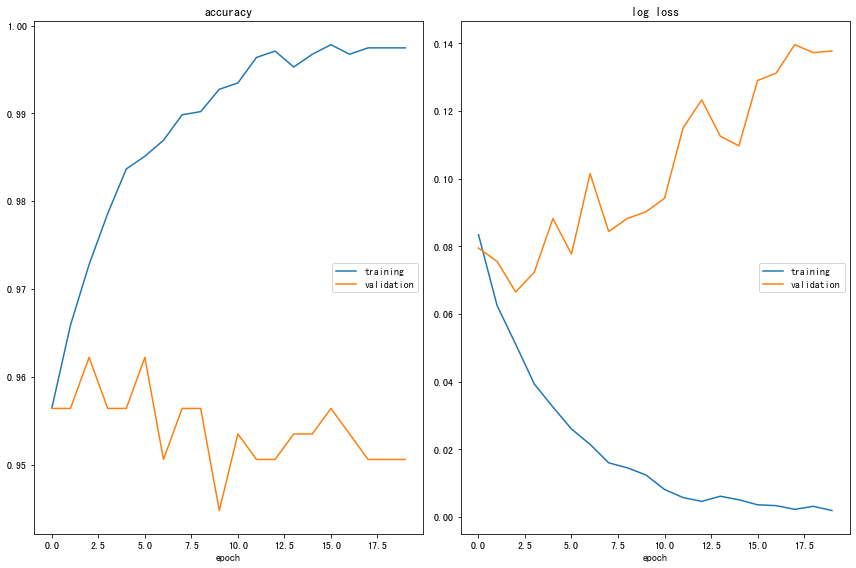

accuracy
	training         	 (min:    0.956, max:    0.998, cur:    0.997)
	validation       	 (min:    0.945, max:    0.962, cur:    0.951)
log loss
	training         	 (min:    0.002, max:    0.083, cur:    0.002)
	validation       	 (min:    0.066, max:    0.140, cur:    0.138)


In [12]:
train_model(dataloaders,model, criterion, optimizer,lr_scheduler,num_epochs=epoch_num)

# 测试集

# 20221208 测试
截断长度为1200 <br>
激活函数是ReLU

In [13]:
def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    model.eval()
    with torch.no_grad():
        for batch,data in enumerate(dataloader,start=1):
            labels = data.labels.to(device)
            input_ids = data.input_ids.to(device)
            token_type_ids = data.token_type_ids.to(device)
            attention_mask = data.attention_mask.to(device)
            pred = model(input_ids,token_type_ids,attention_mask)
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    return correct

In [14]:
valid_acc = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

Test Accuracy: 95.7%

0.9565217391304348
Done!


## 20221209 测试
截断长度为1200 <br>
激活函数Sigmod <br>
validation batch_size 为2

In [14]:
valid_acc = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

Test Accuracy: 95.4%

0.9536231884057971
Done!


In [14]:
valid_acc = test_loop(test_dataloader, model, mode='Test')
print(valid_acc)
print("Done!")

Test Accuracy: 95.4%

0.9536231884057971
Done!
